In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from random import sample

## Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [2]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [3]:
for i, sentence in enumerate(text):
    text[i] = sentence.lower()

In [4]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.

# Your great code here

text_ = ''

for sentence in text:
    text_ += sentence.lower()

assert len(text_) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text_) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [5]:
tokens = set()

for char in text_:
    tokens.update(set(char))

tokens = list(tokens)
num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  38


Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [6]:
# словарь вида <индекс>:<символ>
# Your great code here
id_to_token = {idx: symbol for idx, symbol in enumerate(tokens)}

# словарь вида <символ>:<индекс>
# Your great code here
token_to_id = {symbol: idx for idx, symbol in enumerate(tokens)}

## Полезные функции

In [7]:
def get_sentence(encode_sentence): 
    '''Get decoded sentence from idx representation'''
    
    sentence = ''
    for idx in encode_sentence:
        sentence += id_to_token[int(idx)]
    return sentence


def longest_sentence(corpus):
    '''Get the length of the longest sentence in the corpus'''
    length=0
    for sent in corpus:
        if(len(sent)>length):
            length=len(sent)
    return length


def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [8]:
input_size = num_tokens #input size is equal to the size of the num_tokens  
max_length = longest_sentence(text) #len of the longest sentence in the corpus
batch_size = 32

In [9]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.num_tokens = num_tokens 
        
        self.rnn_update = nn.Linear(num_tokens + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get one-hot representation
        one_hot = self.one_hot_encode(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([one_hot, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)
    
    def one_hot_encode(self, x):
        one_hot = F.one_hot(x, num_classes=self.num_tokens)
        return one_hot.type(torch.FloatTensor)

In [10]:
char_rnn = CharRNNCell(rnn_num_units=128)
criterion = nn.CrossEntropyLoss()

### RNN loop

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [11]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))
        
    return torch.stack(logprobs, dim=1)

In [12]:
batch_ix = to_matrix(text[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [13]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# .contiguous() method checks that tensor is stored in the memory correctly to 
# get its view of desired shape.

loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))

loss.backward()

for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [14]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

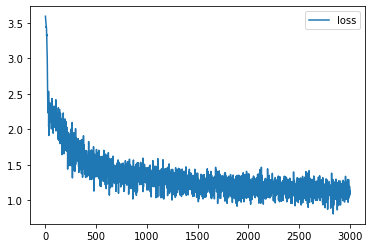

In [16]:
for i in range(3000):
    batch_ix = to_matrix(sample(text, 32), max_len=max_length)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [21]:
def generate_sample(char_rnn, seed_phrase=' h', max_length=max_length, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

for _ in range(20):
    print(generate_sample(char_rnn, temperature=0.5))

 ho do my them not in thee be thou hand,
                      
 ho lough that my soof all in then thes in worne,
             
 han thou my that my shave sear'd dith live
                   
 has me thou domend of ceres dise.
                            
 hat that be ming the my the the thear'd shach whing,
         
 hand the worthe the mo the fore to me whing of bearse.
       
 hand with the song thee be mere's all might;
                 
 hand thou derthe my so the with love.
                        
 hand to the cand and bears now on will shate;
                
 hand hath mo ming in that the thee thy in trougring.
         
 ha the rof at thou the making susser's,
                      
 han thing the in that i thou store,
                          
 hand his thy shougr bear i with the mere,
                    
 have the where hat willd i hat lovering right
                
 han i so she sund do prome thes so beare:
                    
 hand of the the byour the that wore sen

## Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

In [29]:
num_layers = 3
rnn_num_units = 128

In [30]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, rnn_num_units=rnn_num_units, num_layers=num_layers):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.num_units = rnn_num_units
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(num_tokens, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        assert isinstance(x.data, torch.LongTensor)
        
        one_hot = self.one_hot_encode(x)
        
        output, h_next = self.rnn(one_hot, h_prev)
        logits = self.hid_to_logits(output)
        #next_logp = F.log_softmax(next_logits, dim=-1)
        return logits, h_next
    
    def one_hot_encode(self, x):
        one_hot = F.one_hot(x, num_classes=self.num_tokens)
        return one_hot.type(torch.FloatTensor)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """

        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.num_units).zero_(),
                  weight.new(self.num_layers, batch_size, self.num_units).zero_())
        
        return hidden

In [31]:
model = CharRNNLoop()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(text, 32), max_len=max_length)
batch_ix = torch.LongTensor(batch_ix)

batch_size, max_length = batch_ix.shape

hid_state = model.initial_state(batch_size)  #max_length instead of batch_size because batch_first=False

logits, h_hext = model(batch_ix, hid_state)

loss = criterion(logits[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

for w in model.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

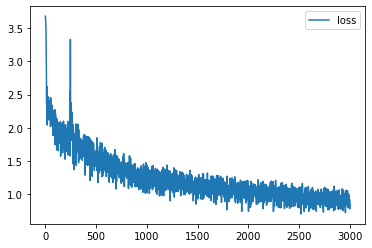

In [32]:
for i in range(3000):
    batch_ix = to_matrix(sample(text, 32), max_len=max_length)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
 
    batch_size, max_length = batch_ix.size()
    
    hid_state = (torch.zeros(num_layers, batch_size, rnn_num_units),
                  torch.zeros(num_layers, batch_size, rnn_num_units)
                )
    
    logits, _ = model(batch_ix, hid_state)
    
    # compute loss
    predictions = logits[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(predictions.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
       
    history.append(loss.data.item())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [38]:
def generate_sample_(char_rnn, seed_phrase=' f', max_length=max_length, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    batch_size, length = x_sequence.shape

    hid_state = (torch.zeros(num_layers, batch_size, rnn_num_units),
                  torch.zeros(num_layers, batch_size, rnn_num_units)
                )

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        _, hid_state = char_rnn(x_sequence[:, i].unsqueeze(0), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logits, hid_state = char_rnn(x_sequence[:, -1].unsqueeze(0), hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0][0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

for _ in range(20):
    print(generate_sample_(model, temperature=0.5))

 from the the beauty be the farther lead,
                     
 fand thy that i deed better thee.
                            
 fas the were in my live and mend
                             
 for my stare more my desire so thee,
                         
 far the lives all the world thou shall spong
                 
 fand the world this the cill goning shee,
                    
 fard the shall to this self that with mind,
                  
 from the show my sight the chanding stoll!
                   
 fam the looks cimer part to thee:
                            
 fthat his is the world not said his siggain
                  
 fhor your in my love, and the show i shall,
                  
 for the your will gart to the wistend,
                       
 fard the creed the words with the days.
                      
 fore time partenss the own in their best,
                    
 fast is thou that i should to thy stand.
                     
 fas the farour of thee thy pourn say
  